In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
df= pd.read_csv('riceClassification.csv')

In [4]:
df.sample(3)

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
16873,16874,8403,158.852144,68.666107,0.901747,8699,103.436125,0.579517,378.562,0.736835,2.313400,0
17291,17292,8330,158.212308,67.511962,0.904385,8565,102.985850,0.745814,370.015,0.764568,2.343471,0
17929,17930,9283,171.022758,70.054016,0.912257,9606,108.717444,0.570419,400.304,0.727978,2.441298,0


In [5]:
df.drop('id',inplace=True,axis=1)

In [6]:
original_df =  df.copy()

In [7]:
X_train , x_temp ,y_train , y_temp = train_test_split(df.drop('Class',axis=1),df['Class'],test_size=.4,random_state=69)
X_valid,X_test,y_valid,y_test = train_test_split(x_temp,y_temp,test_size=.5,random_state=69)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns,index=X_train.index)
# X_valid_scaled = pd.DataFrame(X_valid_scaled,columns=X_valid.columns,index=X_valid.index)
# X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns,index=X_test.index)
    

In [11]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(X,dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y,dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index] , self.Y[index]
        

In [12]:
training_data = dataset(X_train_scaled, y_train.values)
validation_data = dataset(X_valid_scaled, y_valid.values)
test_data = dataset(X_test_scaled, y_test.values)

In [13]:
train_dataloader = DataLoader(training_data,batch_size=32,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=True)

In [14]:
HIDDEN_NEURON = 10 
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer =nn.Linear(df.drop('Class',axis=1).shape[1],HIDDEN_NEURON)
        self.linear = nn.Linear(HIDDEN_NEURON,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [15]:
model = MyModel().to(device)

In [16]:
summary(model,(df.drop('Class',axis=1).shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [17]:
criterion =nn.BCELoss()
optimazer = Adam(model.parameters(),lr=1e-3)

In [18]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


In [19]:
epochs=10
for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_validation = 0
    total_loss_validation = 0

    for data in train_dataloader:
        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = criterion(prediction,labels)

        total_loss_train += batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_train += acc

        
        batch_loss.backward()
        optimazer.step()
        optimazer.zero_grad()

    with torch.no_grad():
        for validation in validation_dataloader:
            inputs  ,labels=validation

            prediction=model(inputs).squeeze(1)
            batch_loss = criterion(prediction,labels)
            total_loss_validation += batch_loss.item()

            acc = (prediction.round()==labels).sum().item()

            total_acc_validation += acc
    
    total_loss_train_plot.append(round(total_loss_train/training_data.__len__(),4))
    total_loss_validation_plot.append(round(total_loss_validation/validation_data.__len__(),4))

    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4))

    print(f'Epoch no.{epoch+1} Train Loss: {total_loss_train_plot[epoch]} Train Accuracy: {total_acc_train_plot[epoch]}')
    print(f'Epoch no.{epoch+1} Validation Loss: {total_loss_validation_plot[epoch]} Validation Accuracy: {total_acc_validation_plot[epoch]}')
    print('='*50)

Epoch no.1 Train Loss: 0.017 Train Accuracy: 89.8543
Epoch no.1 Validation Loss: 0.0108 Validation Accuracy: 98.3228
Epoch no.2 Train Loss: 0.0065 Train Accuracy: 98.332
Epoch no.2 Validation Loss: 0.0039 Validation Accuracy: 98.5703
Epoch no.3 Train Loss: 0.003 Train Accuracy: 98.4144
Epoch no.3 Validation Loss: 0.0024 Validation Accuracy: 98.5703
Epoch no.4 Train Loss: 0.0021 Train Accuracy: 98.5428
Epoch no.4 Validation Loss: 0.0018 Validation Accuracy: 98.5703
Epoch no.5 Train Loss: 0.0018 Train Accuracy: 98.5428
Epoch no.5 Validation Loss: 0.0016 Validation Accuracy: 98.5703
Epoch no.6 Train Loss: 0.0016 Train Accuracy: 98.5336
Epoch no.6 Validation Loss: 0.0015 Validation Accuracy: 98.5428
Epoch no.7 Train Loss: 0.0015 Train Accuracy: 98.5244
Epoch no.7 Validation Loss: 0.0014 Validation Accuracy: 98.7352
Epoch no.8 Train Loss: 0.0014 Train Accuracy: 98.5244
Epoch no.8 Validation Loss: 0.0013 Validation Accuracy: 98.6802
Epoch no.9 Train Loss: 0.0014 Train Accuracy: 98.5886
Epoch

In [20]:
model.eval()
with torch.no_grad():
    total_loss_test =0
    total_acc_test = 0
    for data in test_dataloader:
        inputs,labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss_test = criterion(prediction,labels).item()
        total_loss_test +=batch_loss_test
        
        acc = (prediction.round() == labels).sum().item()

        total_acc_test+= acc

    print(f'Accuracy for TestSet:{round(total_acc_test/test_data.__len__()*100,4)}')


Accuracy for TestSet:98.5703


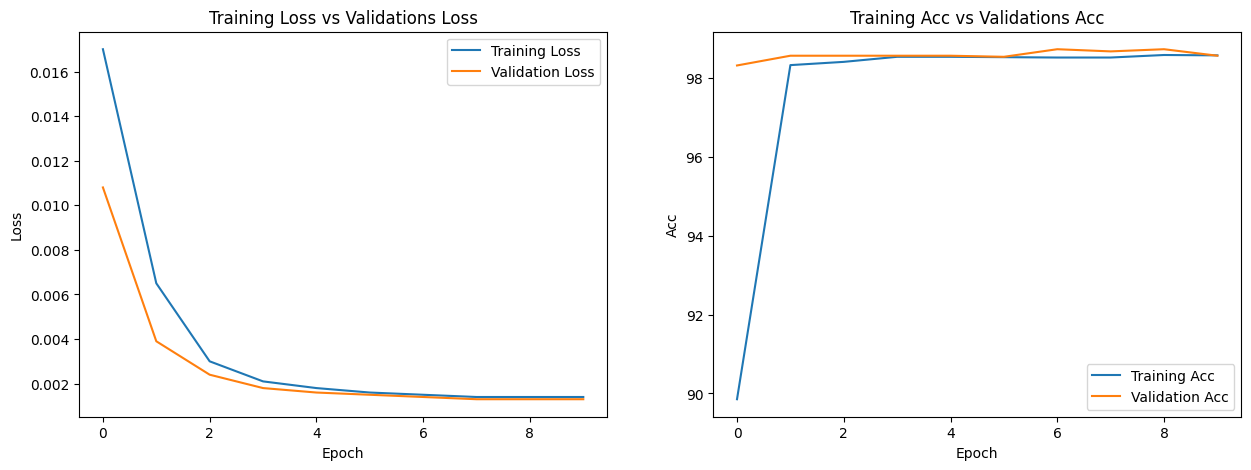

In [21]:
fig,axs=  plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label = 'Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title('Training Loss vs Validations Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label = 'Training Acc')
axs[1].plot(total_acc_validation_plot,label='Validation Acc')
axs[1].set_title('Training Acc vs Validations Acc')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Acc')
axs[1].legend()

In [22]:
area = ((4537 - original_df['Area'].min())/(original_df['Area'].max()-original_df['Area'].min()))

In [23]:
area

np.float64(0.2620967741935484)